# Calibration du modèle de Heston

This notebook illustrates how to calibrate the Heston model to a volatility smile.
The code implements the characteristic function of Heston, calculates option prices,
obtains the implicit volatility via Black–Scholes inversion and proceeds to the
calibration by least squares.


/tmp/ipython-input-3289895879.py:155: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  integral_P1 = _trapz(integrand_P1_real, u)
/tmp/ipython-input-3289895879.py:156: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  integral_P2 = _trapz(integrand_P2_real, u)


Calibrated parameters:
  kappa = 1.877079
  theta = 0.152956
  sigma = 0.637401
  rho   = -0.390031
  v0    = 0.076597

Strike     Market IV      Model IV
  527.50      0.352460      0.350973
  560.46      0.343300      0.343876
  593.43      0.336170      0.337437
  626.40      0.328220      0.331651
  659.37      0.329650      0.326511
  692.34      0.323830      0.322005
  725.31      0.318310      0.318116
  758.28      0.313440      0.314820


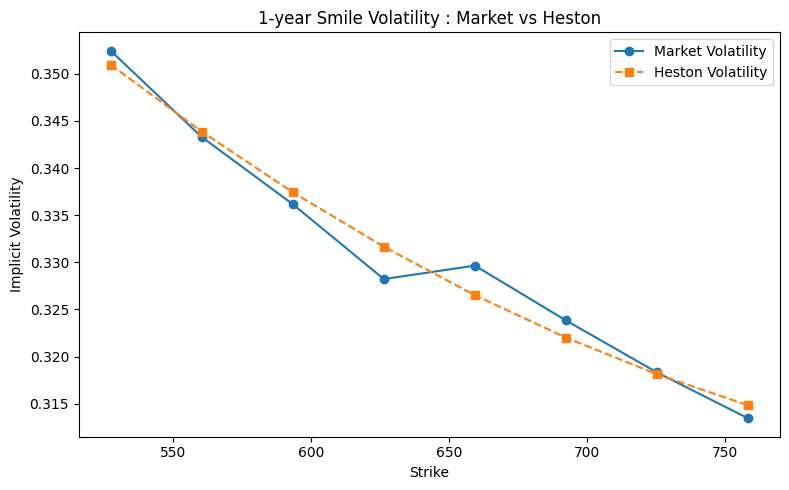

In [2]:
"""
Script to calibrate the parameters of the Heston stochastic volatility model
to a volatility smile observed in option markets.  The calibration targets
a set of implied volatilities for a single maturity and multiple strikes
using a least‑squares fit.  Once calibrated, the script prints the
resulting parameters and compares the model‑implied volatility smile to
the market smile.

The implementation is self contained and does not rely on QuantLib.  It
computes European call option prices under the Heston model via the
semi‑closed form integral representation proposed by Steven Heston.  A
characteristic function for the log stock price is constructed and
numerically integrated to obtain the risk‑neutral probabilities P1 and
P2.  Black–Scholes implied volatilities are then recovered from the
model prices using a root‑finding method.

References
----------
* Steven L. Heston, "A Closed-Form Solution for Options with Stochastic
  Volatility with Applications to Bond and Currency Options," 1993.
* Yiran Cui et al., "Full and fast calibration of the Heston stochastic
  volatility model," 2016: shows that the calibration can be framed as
  a nonlinear least squares problem and solved efficiently with a
  Levenberg–Marquardt method【873220187486589†L48-L61】.
* Goutham Balaraman, "Modeling Volatility Smile and Heston Model
  Calibration Using QuantLib Python," 2016: provides an example data
  set for implied volatilities and demonstrates calibration routines
  based on QuantLib【425300167694903†L276-L335】.
"""

import numpy as np
from numpy import trapz as _trapz
from scipy.stats import norm
from scipy.optimize import least_squares, brentq


def heston_characteristic_function(u: np.ndarray, T: float, *, kappa: float,
                                   theta: float, sigma: float, rho: float,
                                   v0: float, r: float, q: float,
                                   S0: float) -> np.ndarray:
    """Compute the characteristic function φ(u) of log(S_T) for the Heston model.

    The implementation follows the formulation commonly found in the
    literature.  It uses the risk‑neutral measure (λ = 0) and the
    complex‑valued square root required by the Heston solution.  The
    characteristic function φ(u) satisfies

        φ(u) = E[e^{i u X_T}] where X_T = ln(S_T).

    Parameters
    ----------
    u : np.ndarray
        Integration variable (can be complex).  The function returns a
        vector with the same shape as u.
    T : float
        Time to maturity in years.
    kappa, theta, sigma, rho, v0, r, q, S0 : float
        Heston parameters and market data.  See the docstring of
        `heston_price_call` for definitions.

    Returns
    -------
    np.ndarray
        The characteristic function evaluated at u.
    """
    # Precompute constants
    a = kappa * theta
    b = kappa
    # Complex square root for d
    d = np.sqrt((rho * sigma * 1j * u - b) ** 2 + (sigma ** 2) * (1j * u + u ** 2))
    # Avoid division by zero in g by adding a tiny number to the denominator
    g = (b - rho * sigma * 1j * u - d) / (b - rho * sigma * 1j * u + d)
    exp_minus_dT = np.exp(-d * T)
    # Functions C(u,T) and D(u,T) from Heston's solution
    C = r * 1j * u * T + (a / (sigma ** 2)) * (
        (b - rho * sigma * 1j * u - d) * T -
        2.0 * np.log((1.0 - g * exp_minus_dT) / (1.0 - g))
    )
    D = ((b - rho * sigma * 1j * u - d) / (sigma ** 2)) * (
        (1.0 - exp_minus_dT) / (1.0 - g * exp_minus_dT)
    )
    return np.exp(C + D * v0 + 1j * u * (np.log(S0) + (r - q) * T))


def heston_price_call(S0: float, K: float, T: float, r: float, q: float,
                      *, kappa: float, theta: float, sigma: float, rho: float,
                      v0: float, integration_limit: float = 100.0,
                      N: int = 200) -> float:
    """Price a European call option under the Heston model.

    This routine computes the risk‑neutral probabilities P1 and P2 using
    numerical integration of the characteristic function.  It then
    returns the call price via the formula

        C = S0 * exp(-q*T) * P1 - K * exp(-r*T) * P2

    Following Heston (1993),

        P1 = 1/2 + 1/π ∫_0^∞ Re[ e^{-iu ln K} φ(u - i) / (i u φ(-i)) ] du
        P2 = 1/2 + 1/π ∫_0^∞ Re[ e^{-iu ln K} φ(u)     / (i u) ] du

    To evaluate the integrals, we discretise the domain [0, integration_limit]
    into N equally spaced points and use Simpson's rule via scipy.integrate.simps.

    Parameters
    ----------
    S0, K, T, r, q : float
        Spot price, strike price, time to maturity (years), risk‑free rate and
        dividend yield.
    kappa, theta, sigma, rho, v0 : float
        Heston model parameters.  See `heston_characteristic_function`.
    integration_limit : float
        Upper bound of the integration range (truncation point).
    N : int
        Number of grid points in the integration.  A larger N improves
        accuracy but increases computation time.

    Returns
    -------
    float
        The call option price.
    """
    # Create integration grid.  Start slightly above zero to avoid division by
    # zero; a small epsilon ensures numerical stability.
    eps = 1e-8
    u = np.linspace(eps, integration_limit, N)

    # Characteristic function values for shifted and unshifted arguments
    phi_u         = heston_characteristic_function(u, T, kappa=kappa, theta=theta,
                                                    sigma=sigma, rho=rho, v0=v0,
                                                    r=r, q=q, S0=S0)
    phi_u_minus_i = heston_characteristic_function(u - 1j, T, kappa=kappa, theta=theta,
                                                    sigma=sigma, rho=rho, v0=v0,
                                                    r=r, q=q, S0=S0)
    phi_minus_i   = heston_characteristic_function(-1j, T, kappa=kappa, theta=theta,
                                                    sigma=sigma, rho=rho, v0=v0,
                                                    r=r, q=q, S0=S0)

    # Common factors for P1 and P2 integrals
    exp_neg_i_u_logK = np.exp(-1j * u * np.log(K))
    # Avoid division by zero in denominators
    denom_common = 1j * u

    # Integrands for P1 and P2
    # P1 integrand: e^{-iu log K} * φ(u - i) / (i u φ(-i))
    integrand_P1 = (exp_neg_i_u_logK * phi_u_minus_i) / (denom_common * phi_minus_i)
    # P2 integrand: e^{-iu log K} * φ(u) / (i u)
    integrand_P2 = (exp_neg_i_u_logK * phi_u) / denom_common
    # Take real parts
    integrand_P1_real = np.real(integrand_P1)
    integrand_P2_real = np.real(integrand_P2)

    # Numerical integration via the trapezoidal rule.  Using numpy.trapz
    # provides reasonable accuracy for a smooth integrand.
    integral_P1 = _trapz(integrand_P1_real, u)
    integral_P2 = _trapz(integrand_P2_real, u)

    P1 = 0.5 + (1.0 / np.pi) * integral_P1
    P2 = 0.5 + (1.0 / np.pi) * integral_P2

    return S0 * np.exp(-q * T) * P1 - K * np.exp(-r * T) * P2


def bs_price_call(S0: float, K: float, T: float, r: float, sigma: float,
                   q: float = 0.0) -> float:
    """Black–Scholes price of a European call option.

    Parameters
    ----------
    S0, K, T, r, sigma : float
        Spot price, strike, maturity (years), risk‑free rate and volatility.
    q : float, optional
        Dividend yield.

    Returns
    -------
    float
        The Black–Scholes call price.
    """
    if T <= 0:
        return max(S0 - K, 0.0)
    sqrtT = np.sqrt(T)
    d1 = (np.log(S0 / K) + (r - q + 0.5 * sigma ** 2) * T) / (sigma * sqrtT)
    d2 = d1 - sigma * sqrtT
    return S0 * np.exp(-q * T) * norm.cdf(d1) - K * np.exp(-r * T) * norm.cdf(d2)


def implied_vol_call(price: float, S0: float, K: float, T: float, r: float,
                     q: float = 0.0, tol: float = 1e-8) -> float:
    """Compute the Black–Scholes implied volatility for a given call price.

    Uses Brent's method to find σ such that BS_price_call(S0,K,T,r,σ) ≈ price.
    If the price is out of the arbitrage bounds, this function may fail.

    Parameters
    ----------
    price : float
        Observed option price.
    S0, K, T, r : float
        Spot price, strike, maturity (years) and risk‑free rate.
    q : float, optional
        Dividend yield.
    tol : float, optional
        Tolerance for the root solver.

    Returns
    -------
    float
        The implied volatility.
    """
    # Define the objective function for root finding
    def _bs_diff(sigma: float) -> float:
        return bs_price_call(S0, K, T, r, sigma, q) - price
    # Use a wide bracket for volatility; typical implied vols range between 0.01 and 5
    return brentq(_bs_diff, 1e-8, 5.0, xtol=tol)


def calibrate_heston(S0: float, strikes: list, market_vols: list, T: float,
                     r: float, q: float = 0.0) -> dict:
    """Calibrate the Heston model parameters to a volatility smile.

    The function solves a least‑squares problem over the five Heston
    parameters (κ, θ, σ, ρ, v₀).  It returns a dictionary containing the
    calibrated parameters and diagnostic information.

    Parameters
    ----------
    S0 : float
        Spot price of the underlying asset.
    strikes : list of float
        Strike prices used in calibration.
    market_vols : list of float
        Market implied volatilities (same length as `strikes`).
    T : float
        Time to maturity (years) corresponding to the implied volatilities.
    r : float
        Risk‑free interest rate.
    q : float, optional
        Dividend yield.

    Returns
    -------
    dict
        Keys: 'params' (tuple of calibrated parameters), 'result' (LeastSquaresResult),
        'model_vols' (array of model implied vols at optimum).
    """
    strikes = np.asarray(strikes, dtype=float)
    market_vols = np.asarray(market_vols, dtype=float)

    # Define the objective function: returns a vector of differences between
    # model implied volatilities and market vols
    def objective(x: np.ndarray) -> np.ndarray:
        kappa, theta, sigma, rho, v0 = x
        # Enforce parameter bounds manually to avoid non‑physical values during
        # optimisation; the least_squares call also enforces bounds, but
        # clipping here prevents NaNs in the pricing functions.
        kappa = max(kappa, 1e-6)
        theta = max(theta, 1e-6)
        sigma = max(sigma, 1e-6)
        v0    = max(v0,    1e-6)
        rho   = np.clip(rho, -0.999, 0.999)
        model_vols = []
        for K, market_iv in zip(strikes, market_vols):
            price = heston_price_call(S0, K, T, r, q,
                                      kappa=kappa, theta=theta, sigma=sigma,
                                      rho=rho, v0=v0)
            try:
                iv = implied_vol_call(price, S0, K, T, r, q)
            except Exception:
                # If implied vol fails to converge (e.g. out of bounds), penalise heavily
                iv = 10.0
            model_vols.append(iv)
        model_vols = np.array(model_vols)
        return model_vols - market_vols

    # Initial guess and bounds.  Reasonable initial values are taken
    # from the literature; these can be tuned depending on the asset.
    x0 = np.array([1.0, 0.05, 0.3, -0.5, 0.05])  # kappa, theta, sigma, rho, v0
    lower_bounds = [1e-6, 1e-6, 1e-6, -0.999, 1e-6]
    upper_bounds = [10.0, 1.0, 5.0, 0.999, 1.0]

    result = least_squares(objective, x0, bounds=(lower_bounds, upper_bounds),
                           xtol=1e-6, ftol=1e-6, gtol=1e-6, method='trf')
    # Extract calibrated parameters and compute model vols at optimum
    params = result.x
    kappa, theta, sigma, rho, v0 = params
    model_vols_opt = []
    for K in strikes:
        price = heston_price_call(S0, K, T, r, q,
                                  kappa=kappa, theta=theta, sigma=sigma,
                                  rho=rho, v0=v0)
        model_vols_opt.append(implied_vol_call(price, S0, K, T, r, q))
    model_vols_opt = np.array(model_vols_opt)

    return {
        'params': params,
        'result': result,
        'model_vols': model_vols_opt
    }


def main():
    """Run a calibration example using sample data from Goutham Balaraman.

    We calibrate the Heston model parameters to the 1‑year volatility smile
    presented in Balaraman's blog post.  The strikes and implied volatilities
    are hard‑coded for demonstration purposes.  After calibration, the
    calibrated parameters and the model‑implied smile are printed, and a
    comparison plot is generated.
    """
    import matplotlib.pyplot as plt

    # Market data from Balaraman (1‑year row, 12th row of the vol matrix)
    S0 = 659.37
    r = 0.01  # risk‑free rate
    q = 0.0   # dividend yield
    T = 1.0   # maturity in years (approximate)
    strikes = [527.50, 560.46, 593.43, 626.40, 659.37, 692.34, 725.31, 758.28]
    # Volatilities from the 1‑year row (index 11) of the dataset
    market_vols = [
        0.35246, 0.34330, 0.33617, 0.32822,
        0.32965, 0.32383, 0.31831, 0.31344
    ]

    # Calibrate the Heston model
    calib = calibrate_heston(S0, strikes, market_vols, T, r, q)
    params = calib['params']
    model_vols = calib['model_vols']

    print("Calibrated parameters:")
    print(f"  kappa = {params[0]:.6f}")
    print(f"  theta = {params[1]:.6f}")
    print(f"  sigma = {params[2]:.6f}")
    print(f"  rho   = {params[3]:.6f}")
    print(f"  v0    = {params[4]:.6f}")

    # Display model vs market implied vols
    print("\nStrike     Market IV      Model IV")
    for K, mkt_iv, mdl_iv in zip(strikes, market_vols, model_vols):
        print(f"{K:8.2f}    {mkt_iv:10.6f}    {mdl_iv:10.6f}")

    # Plot comparison
    plt.figure(figsize=(8, 5))
    plt.plot(strikes, market_vols, 'o-', label='Market Volatility')
    plt.plot(strikes, model_vols, 's--', label='Heston Volatility')
    plt.xlabel('Strike')
    plt.ylabel('Implicit Volatility')
    plt.title('1-year Smile Volatility : Market vs Heston')
    plt.legend()
    plt.tight_layout()
    plt.show()


if __name__ == '__main__':
    main()